# Lets build a model that can predict my 5k, 10k, half and full marathon time based on my running!

In [253]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


# versions
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"seaborn: {sns.__version__}")
import sklearn
print(f"scikit-learn: {sklearn.__version__}")


pandas: 2.3.0
numpy: 2.3.0
seaborn: 0.13.2
scikit-learn: 1.7.0


# Prepping the data  
This will go through the processing and cleaning of the data to get it prepped for going into the models.

In [254]:

# loading in the activity data
run_data = pd.read_csv("/Users/Nicole/strava_running/personal_running_data/activities.csv")

# attaching the lat/longs to get locations
lat_long_dat = pd.read_csv("/Users/Nicole/strava_running/personal_running_data/output_coordinates.csv")

# making the colums code frienly
run_data.columns = (
    run_data.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace(r'[^\w_]', '', regex=True)  # remove punctuation
)

# renaming the lat long file id to the correct id for merging
lat_long_dat.rename(columns={"file_id": "gps_id"}, inplace=True)

In [255]:
# getting the lat/long ids
run_data['gps_id'] = run_data['filename'].where(~(run_data['filename'].isna() | (run_data['filename'] == '#error#')), run_data['activity_id'])

# Now extract numeric ID from the file name so that i can merge in the lat/long data 
run_data['gps_id'] = run_data['filename'].str.extract(r'(\d+)')
run_data['gps_id'] = run_data['gps_id'].astype(str)
lat_long_dat['gps_id'] = lat_long_dat['gps_id'].astype(str)
run_data['gps_id'] = run_data['gps_id'].where(~run_data['gps_id'].isin(['nan']), run_data['activity_id'])

# merging the lat longs in 
run_data = run_data.merge(lat_long_dat, on="gps_id", how = "left")

In [256]:
# filtering out to keep only the running data
run_data2=run_data[run_data["exercise_type"]=="Run"].copy()

In [257]:

# converting these to numeric to i can convert to miles so i can understand the data
run_data2['distance'] = pd.to_numeric(run_data2['distance'], errors='coerce')
run_data2['moving_time'] = pd.to_numeric(run_data2['moving_time'], errors='coerce')
run_data2['average_speed'] = pd.to_numeric(run_data2['average_speed'], errors='coerce')
run_data2['max_speed'] = pd.to_numeric(run_data2['max_speed'], errors='coerce')

# converting the data from km to miles
run_data2['time_minutes'] = run_data2['moving_time'] / 60
run_data2['distance_miles'] = run_data2['distance'] * 0.621371
run_data2['pace'] = run_data2['time_minutes'] / run_data2['distance_miles']

# speed is in weird meters/sec which makes no sense so converting it
run_data2['avg_speed_mph'] = run_data2['average_speed'] *2.23694
run_data2['max_speed_mph'] = run_data2['max_speed'] * 2.23694

# formatting the date
run_data2['activity_date'] = pd.to_datetime(run_data2['activity_date'], format='%b %d, %Y, %I:%M:%S %p')

# could add in the calculate VO2 Max...
# VO₂ max (ml/kg/min) ≈ (velocity × 0.2) + (grade × velocity × 0.9) + 3.5

## identifying outliers and removing them
looking for outliers and cleaning the data

In [258]:
#creating the global deact column
run_data2["deactivate"] = False

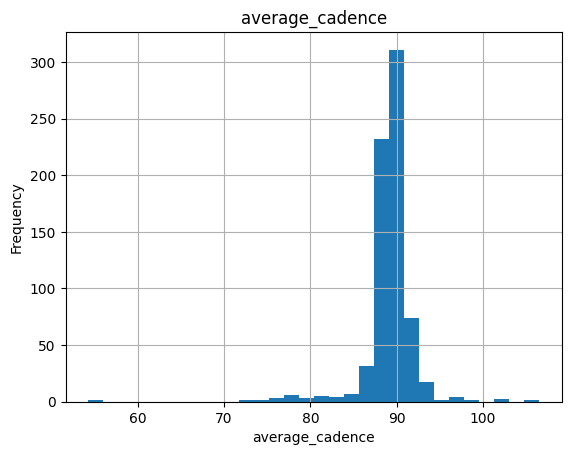

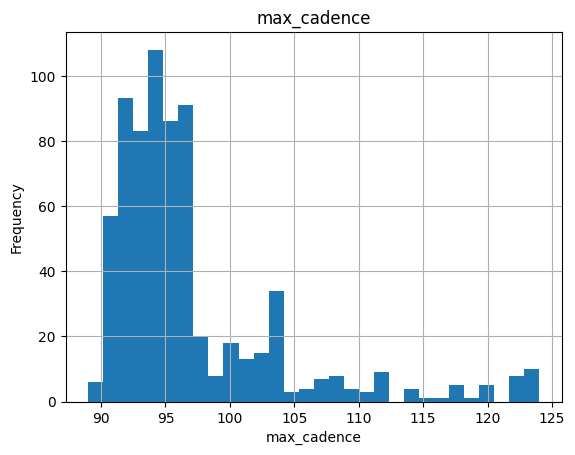

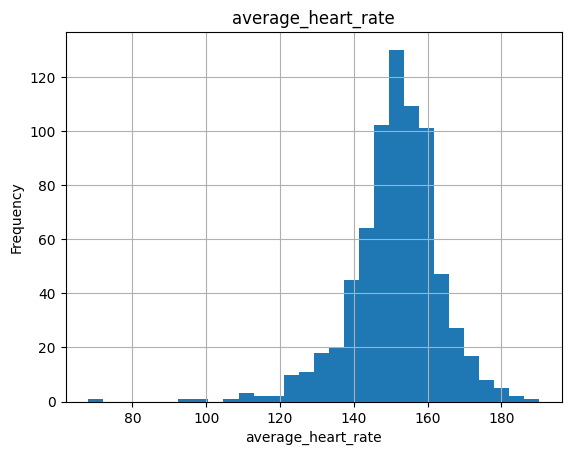

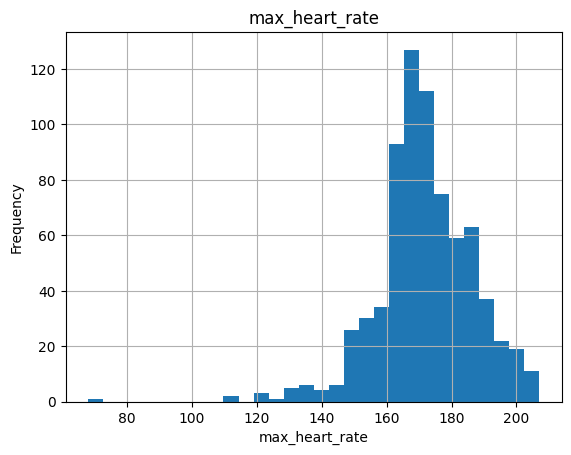

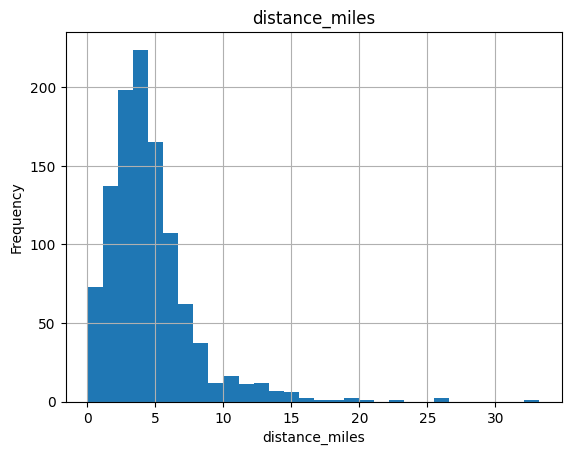

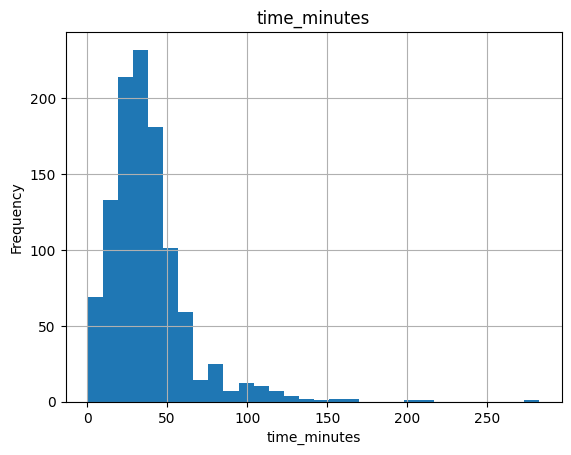

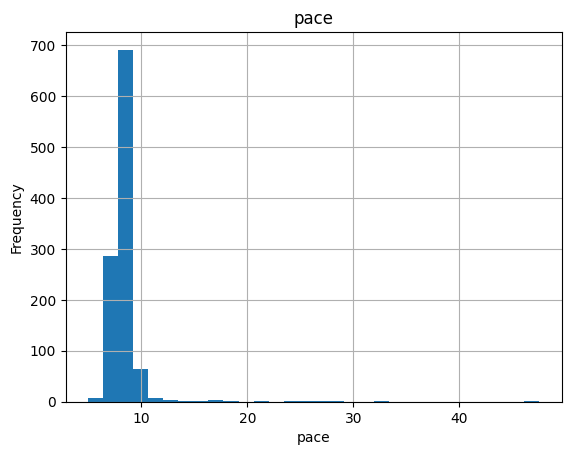

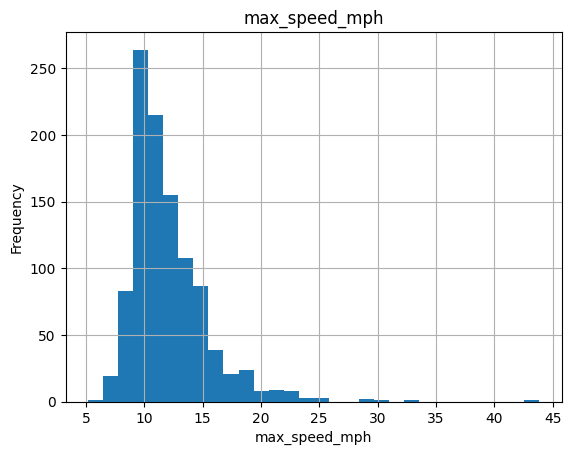

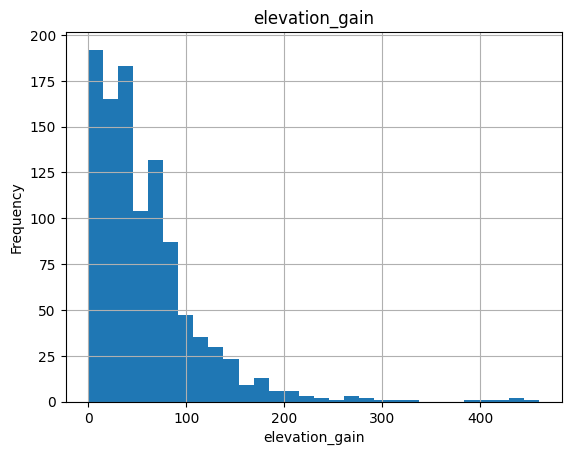

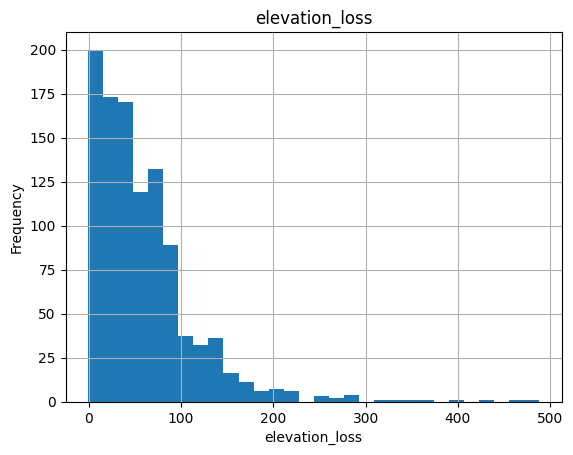

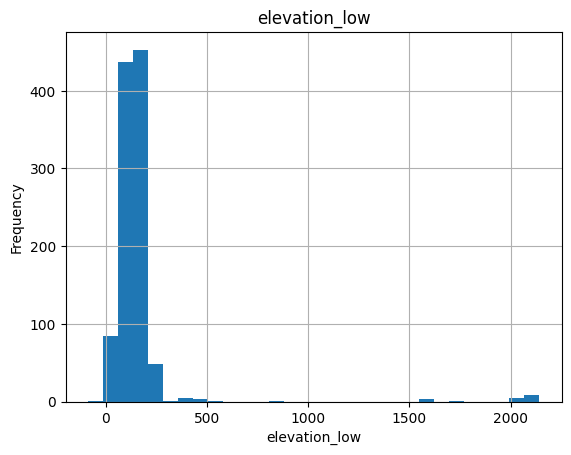

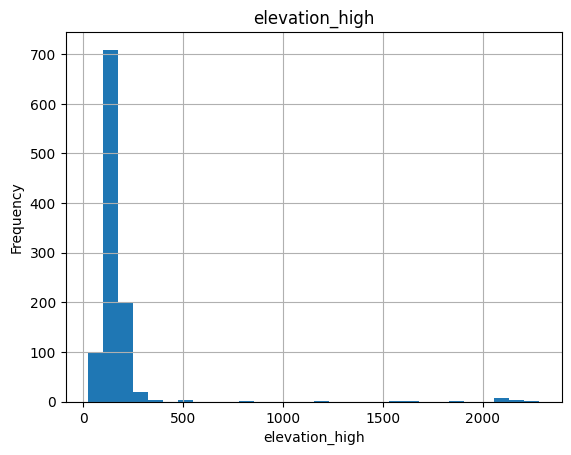

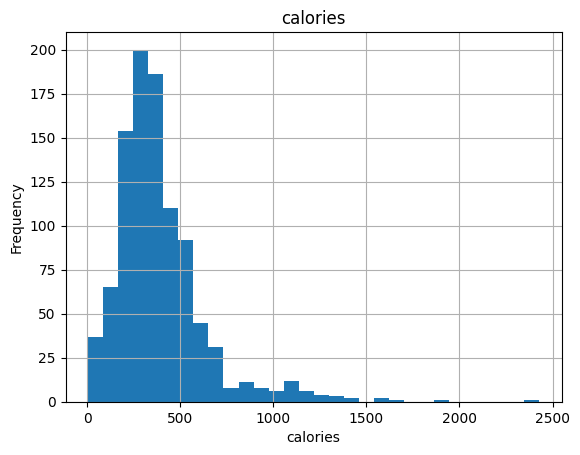

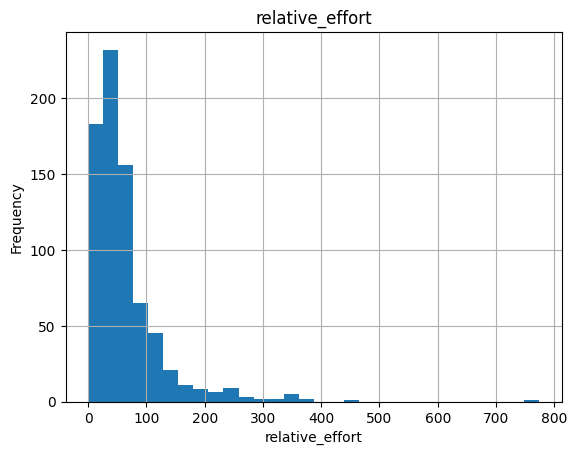

In [259]:
# making histograms of the traits for visulization

cols = ['average_cadence',"max_cadence", 'average_heart_rate','max_heart_rate' ,'distance_miles', "time_minutes", 'pace', 'max_speed_mph', "elevation_gain", "elevation_loss", "elevation_low", "elevation_high", "calories", 'relative_effort']

for col in cols:
    df=run_data2[run_data2["deactivate"]==False]
    plt.figure()
    df[col].hist(bins=30)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


Remove outliers and re run above histograms

In [260]:
# these should be global deactivation, so the whole data point associated here is removed.

# anything over 10mins/ mile is not a normal run for me and probably not an actual run 
run_data2.loc[run_data2["pace"] > 10, "deactivate"] = True

# anything that is >20mph is prolly wrong as Usain bolt peaked at 27mph when he broke the world record (15mph is also 4min mile pace, which is possible)
# there's definitely some error in predicting max speed on the watch so giving some leiniency 
run_data2.loc[run_data2["max_speed_mph"]>20, "deactivate"] = True

# anything under 120 max heart rate is probalby also wrong and also average heart rate less than 105
run_data2.loc[run_data2["max_heart_rate"]<120, "deactivate"] = True
run_data2.loc[run_data2["average_heart_rate"]<105, "deactivate"] = True

# average cadence less than 70, also not a run
run_data2.loc[run_data2["average_cadence"]<70, "deactivate"] = True


In [261]:
# how many are deactivated
print(run_data2['deactivate'].value_counts())

deactivate
False    997
True      81
Name: count, dtype: int64


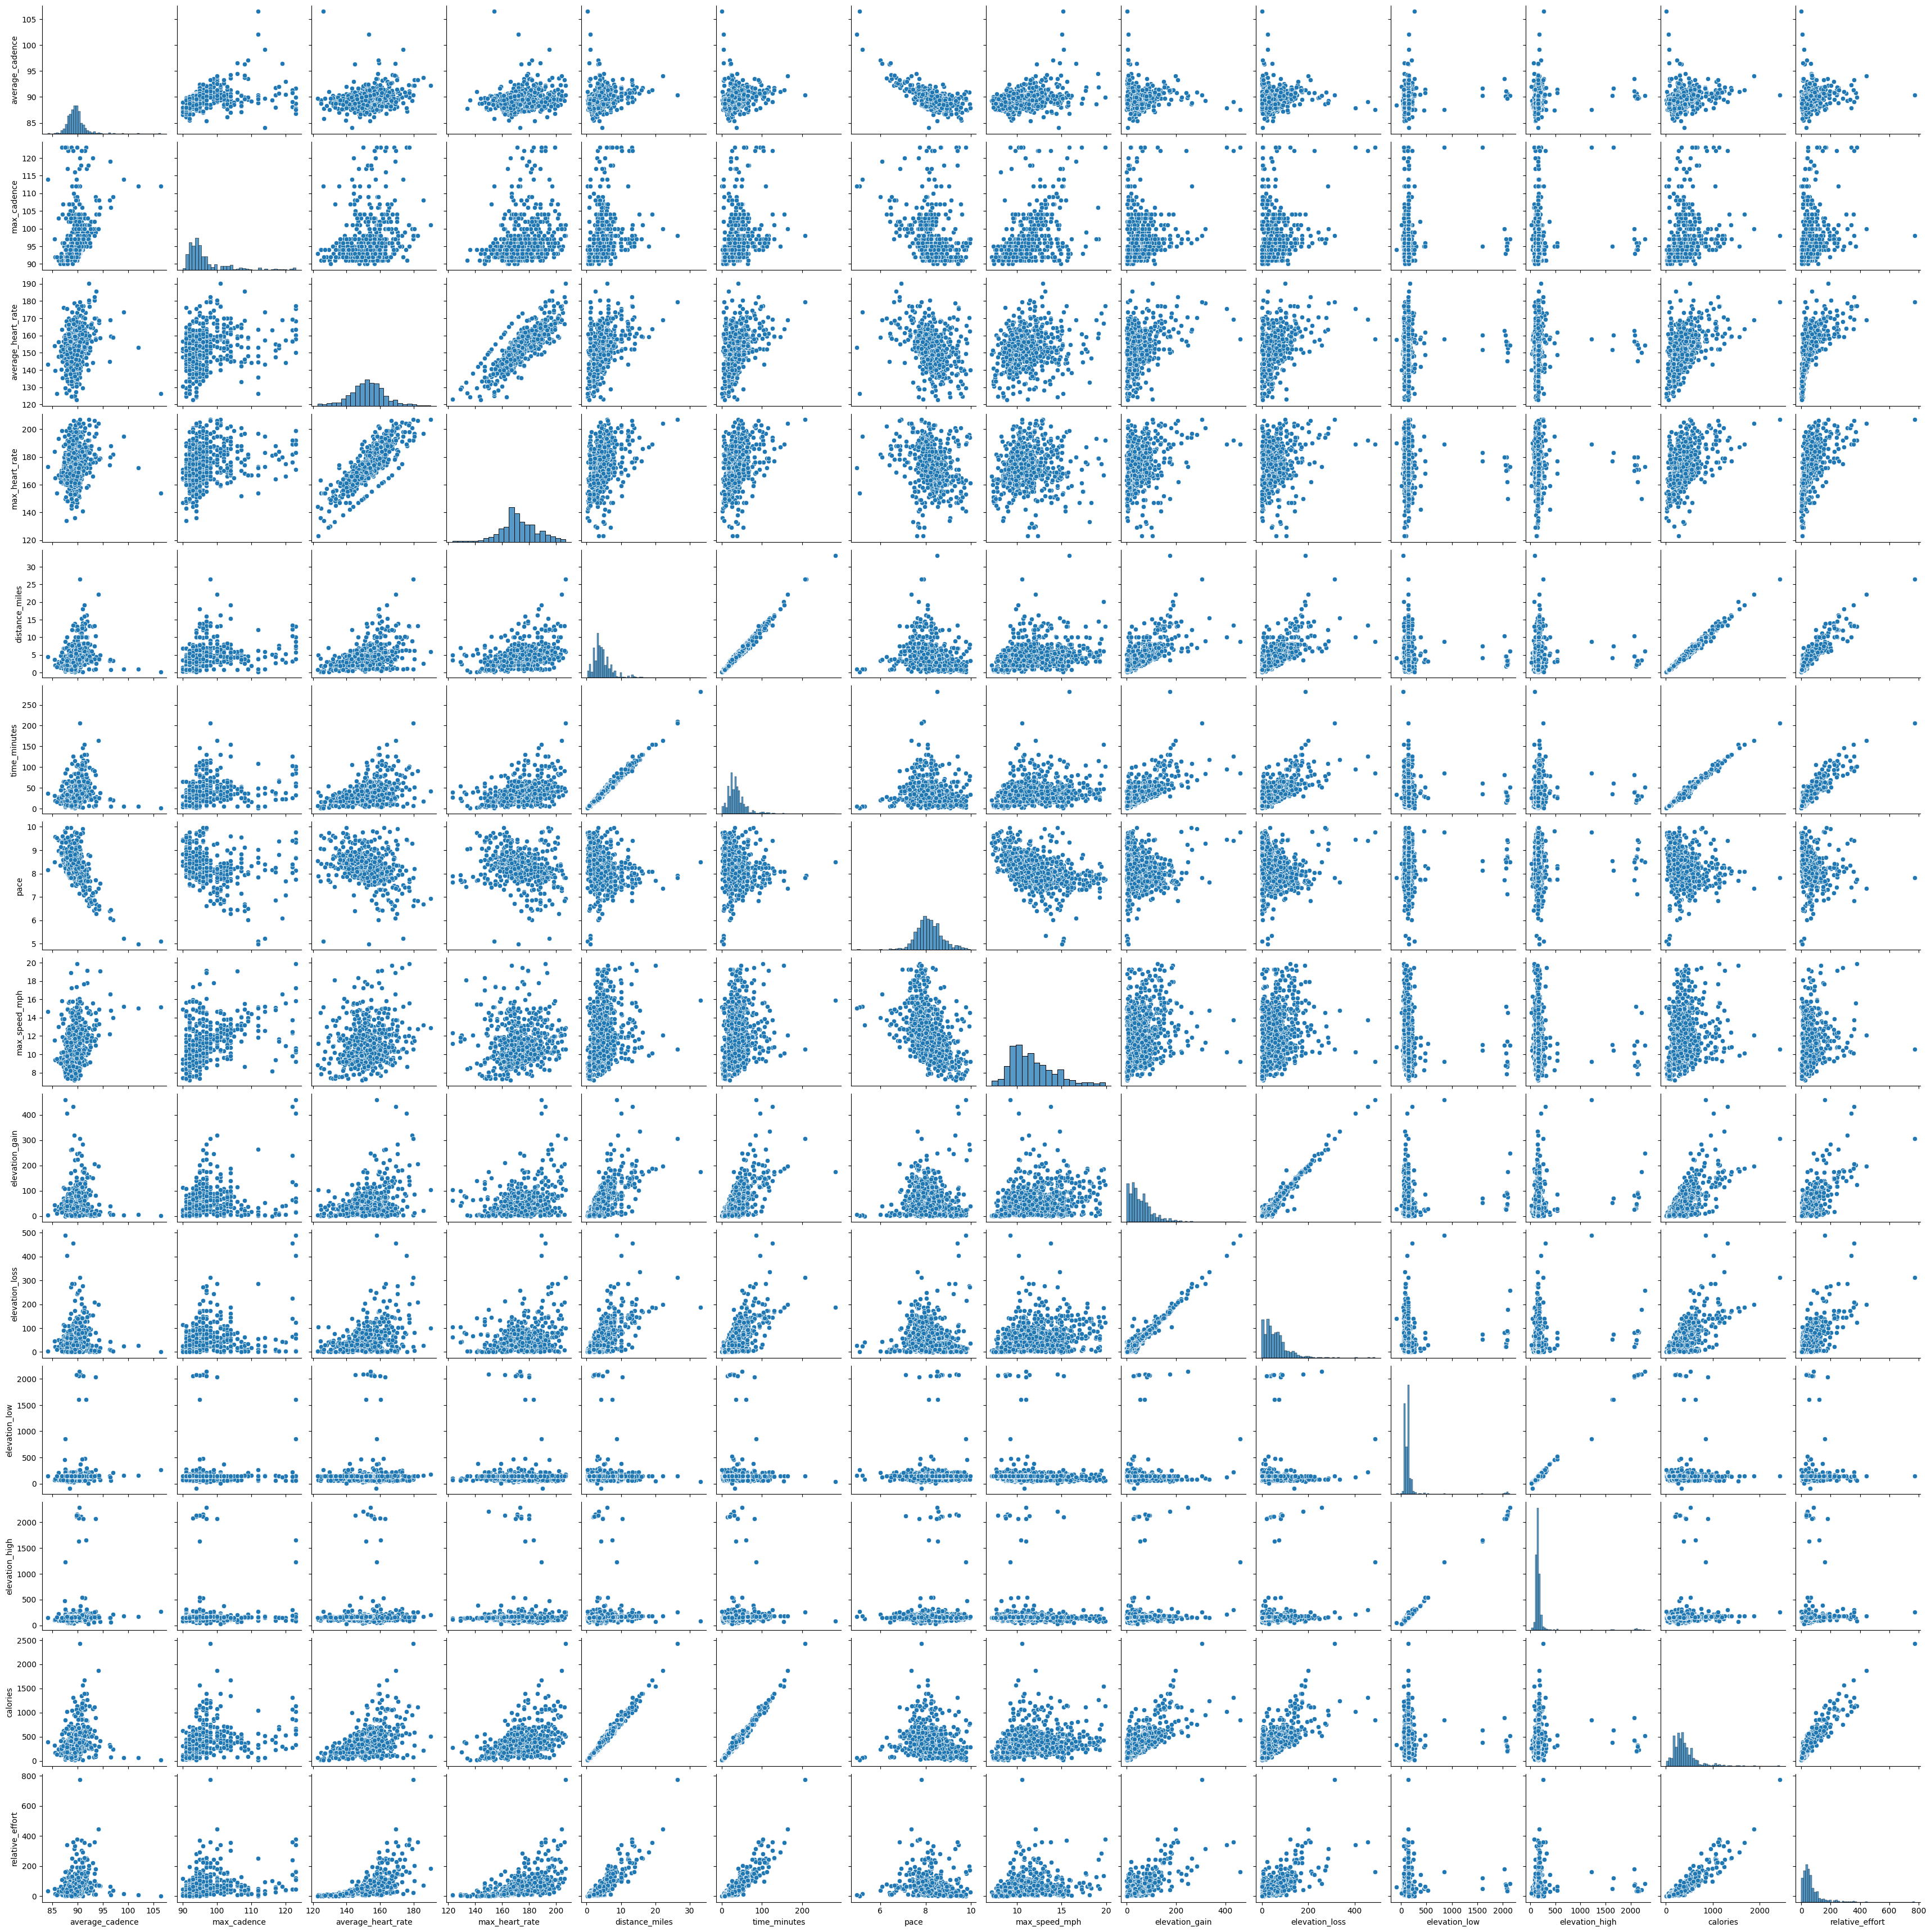

In [262]:
# looking at relationships between variables, some highly correlated variables 
df = run_data2[run_data2['deactivate']==False]
sns.pairplot(df, vars=cols)
plt.show()

In [263]:
# now how much missing data do i have and how am i going to impute the missing data

# carloires -  can use distance to impute
# elevation high or low can probably see what the average elevateion was for lat/long and replace with that 
# elevation gain or loss should prolly be set to 0
# max speed mph set to the average
# max heart rate, use average heart rate where i can, then impute to the average
# average heart rate use max heart rate where i can, then impute to the average

# avergage cadence set to the mean
# max cadence set to the mean
#

cols = ['average_cadence',"max_cadence", 'average_heart_rate','max_heart_rate' ,'distance_miles', "time_minutes", 'pace', 'max_speed_mph', "elevation_gain", "elevation_loss", "elevation_low", "elevation_high", "calories", 'relative_effort']

missing_counts = run_data2[cols].isna().sum()
print(missing_counts)


average_cadence       373
max_cadence           373
average_heart_rate    350
max_heart_rate        342
distance_miles          0
time_minutes            0
pace                    0
max_speed_mph          26
elevation_gain         26
elevation_loss         27
elevation_low          27
elevation_high         27
calories               93
relative_effort       326
dtype: int64


In [264]:
# see how much missing data is by year

run_data2['year'] = run_data2['activity_date'].dt.year  
missing_by_year = run_data2.groupby('year')[cols].apply(lambda df: df.isna().sum())
print(missing_by_year)

      average_cadence  max_cadence  average_heart_rate  max_heart_rate  \
year                                                                     
2020              207          207                 198             190   
2021              153          153                 132             132   
2022                6            6                   6               6   
2023                1            1                   2               2   
2024                5            5                   5               5   
2025                1            1                   7               7   

      distance_miles  time_minutes  pace  max_speed_mph  elevation_gain  \
year                                                                      
2020               0             0     0              5               5   
2021               0             0     0             12              12   
2022               0             0     0              6               6   
2023               0            

In [265]:
# want to see the missing data by month 
run_data2['year_month'] = run_data2['activity_date'].dt.to_period('M')
missing_by_month = run_data2.groupby('year_month')[cols].apply(lambda df: df.isna().sum())
missing_total_by_month = missing_by_month.sum(axis=1)  # total missing per month


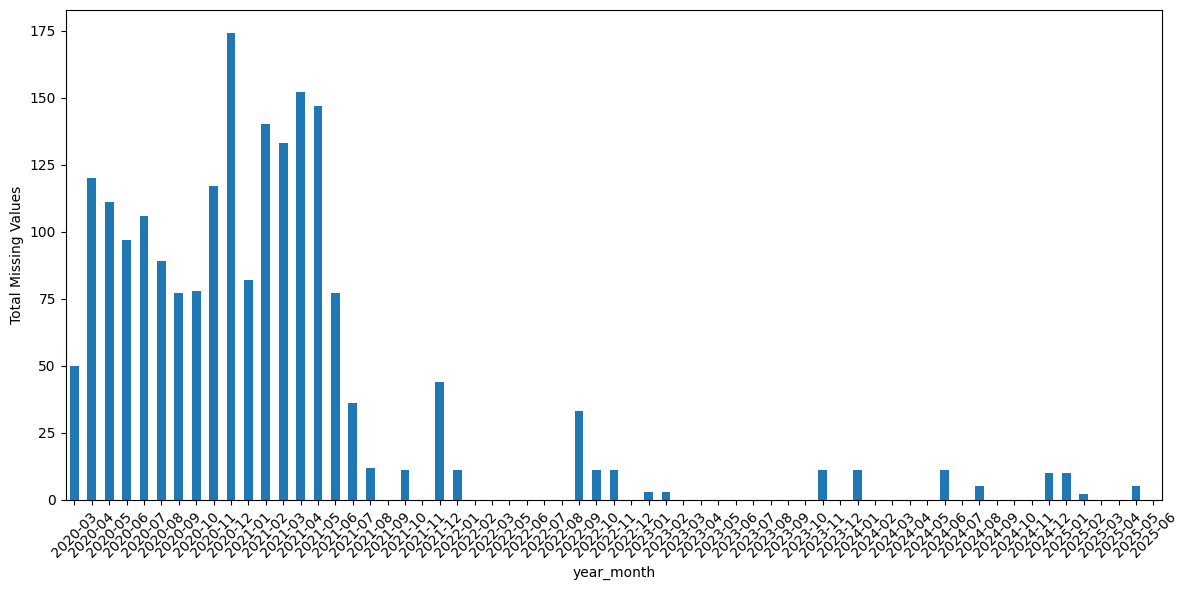

In [266]:
# plotting the missing data. its interesting because i switched from an appple watch to a garmin in august 5th 2021, 
# so i think it's best to remove the columns prior to this month for data integrity
missing_total_by_month.plot(kind='bar', figsize=(12, 6))
plt.ylabel("Total Missing Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [267]:
# going to filter out anything before august 5 2021 as that is when i got a new watch
run_data2=run_data2[run_data2['activity_date']>= '2021-08-05']

In [268]:
# re look at misssing data - missing data decreases dramatically. good because imputation isn't great but i can imput these few missing points
run_data2['year'] = run_data2['activity_date'].dt.year  
missing_by_year = run_data2.groupby('year')[cols].apply(lambda df: df.isna().sum())
print(missing_by_year)

      average_cadence  max_cadence  average_heart_rate  max_heart_rate  \
year                                                                     
2021                5            5                   6               6   
2022                6            6                   6               6   
2023                1            1                   2               2   
2024                5            5                   5               5   
2025                1            1                   7               7   

      distance_miles  time_minutes  pace  max_speed_mph  elevation_gain  \
year                                                                      
2021               0             0     0              5               5   
2022               0             0     0              6               6   
2023               0             0     0              1               1   
2024               0             0     0              2               2   
2025               0           

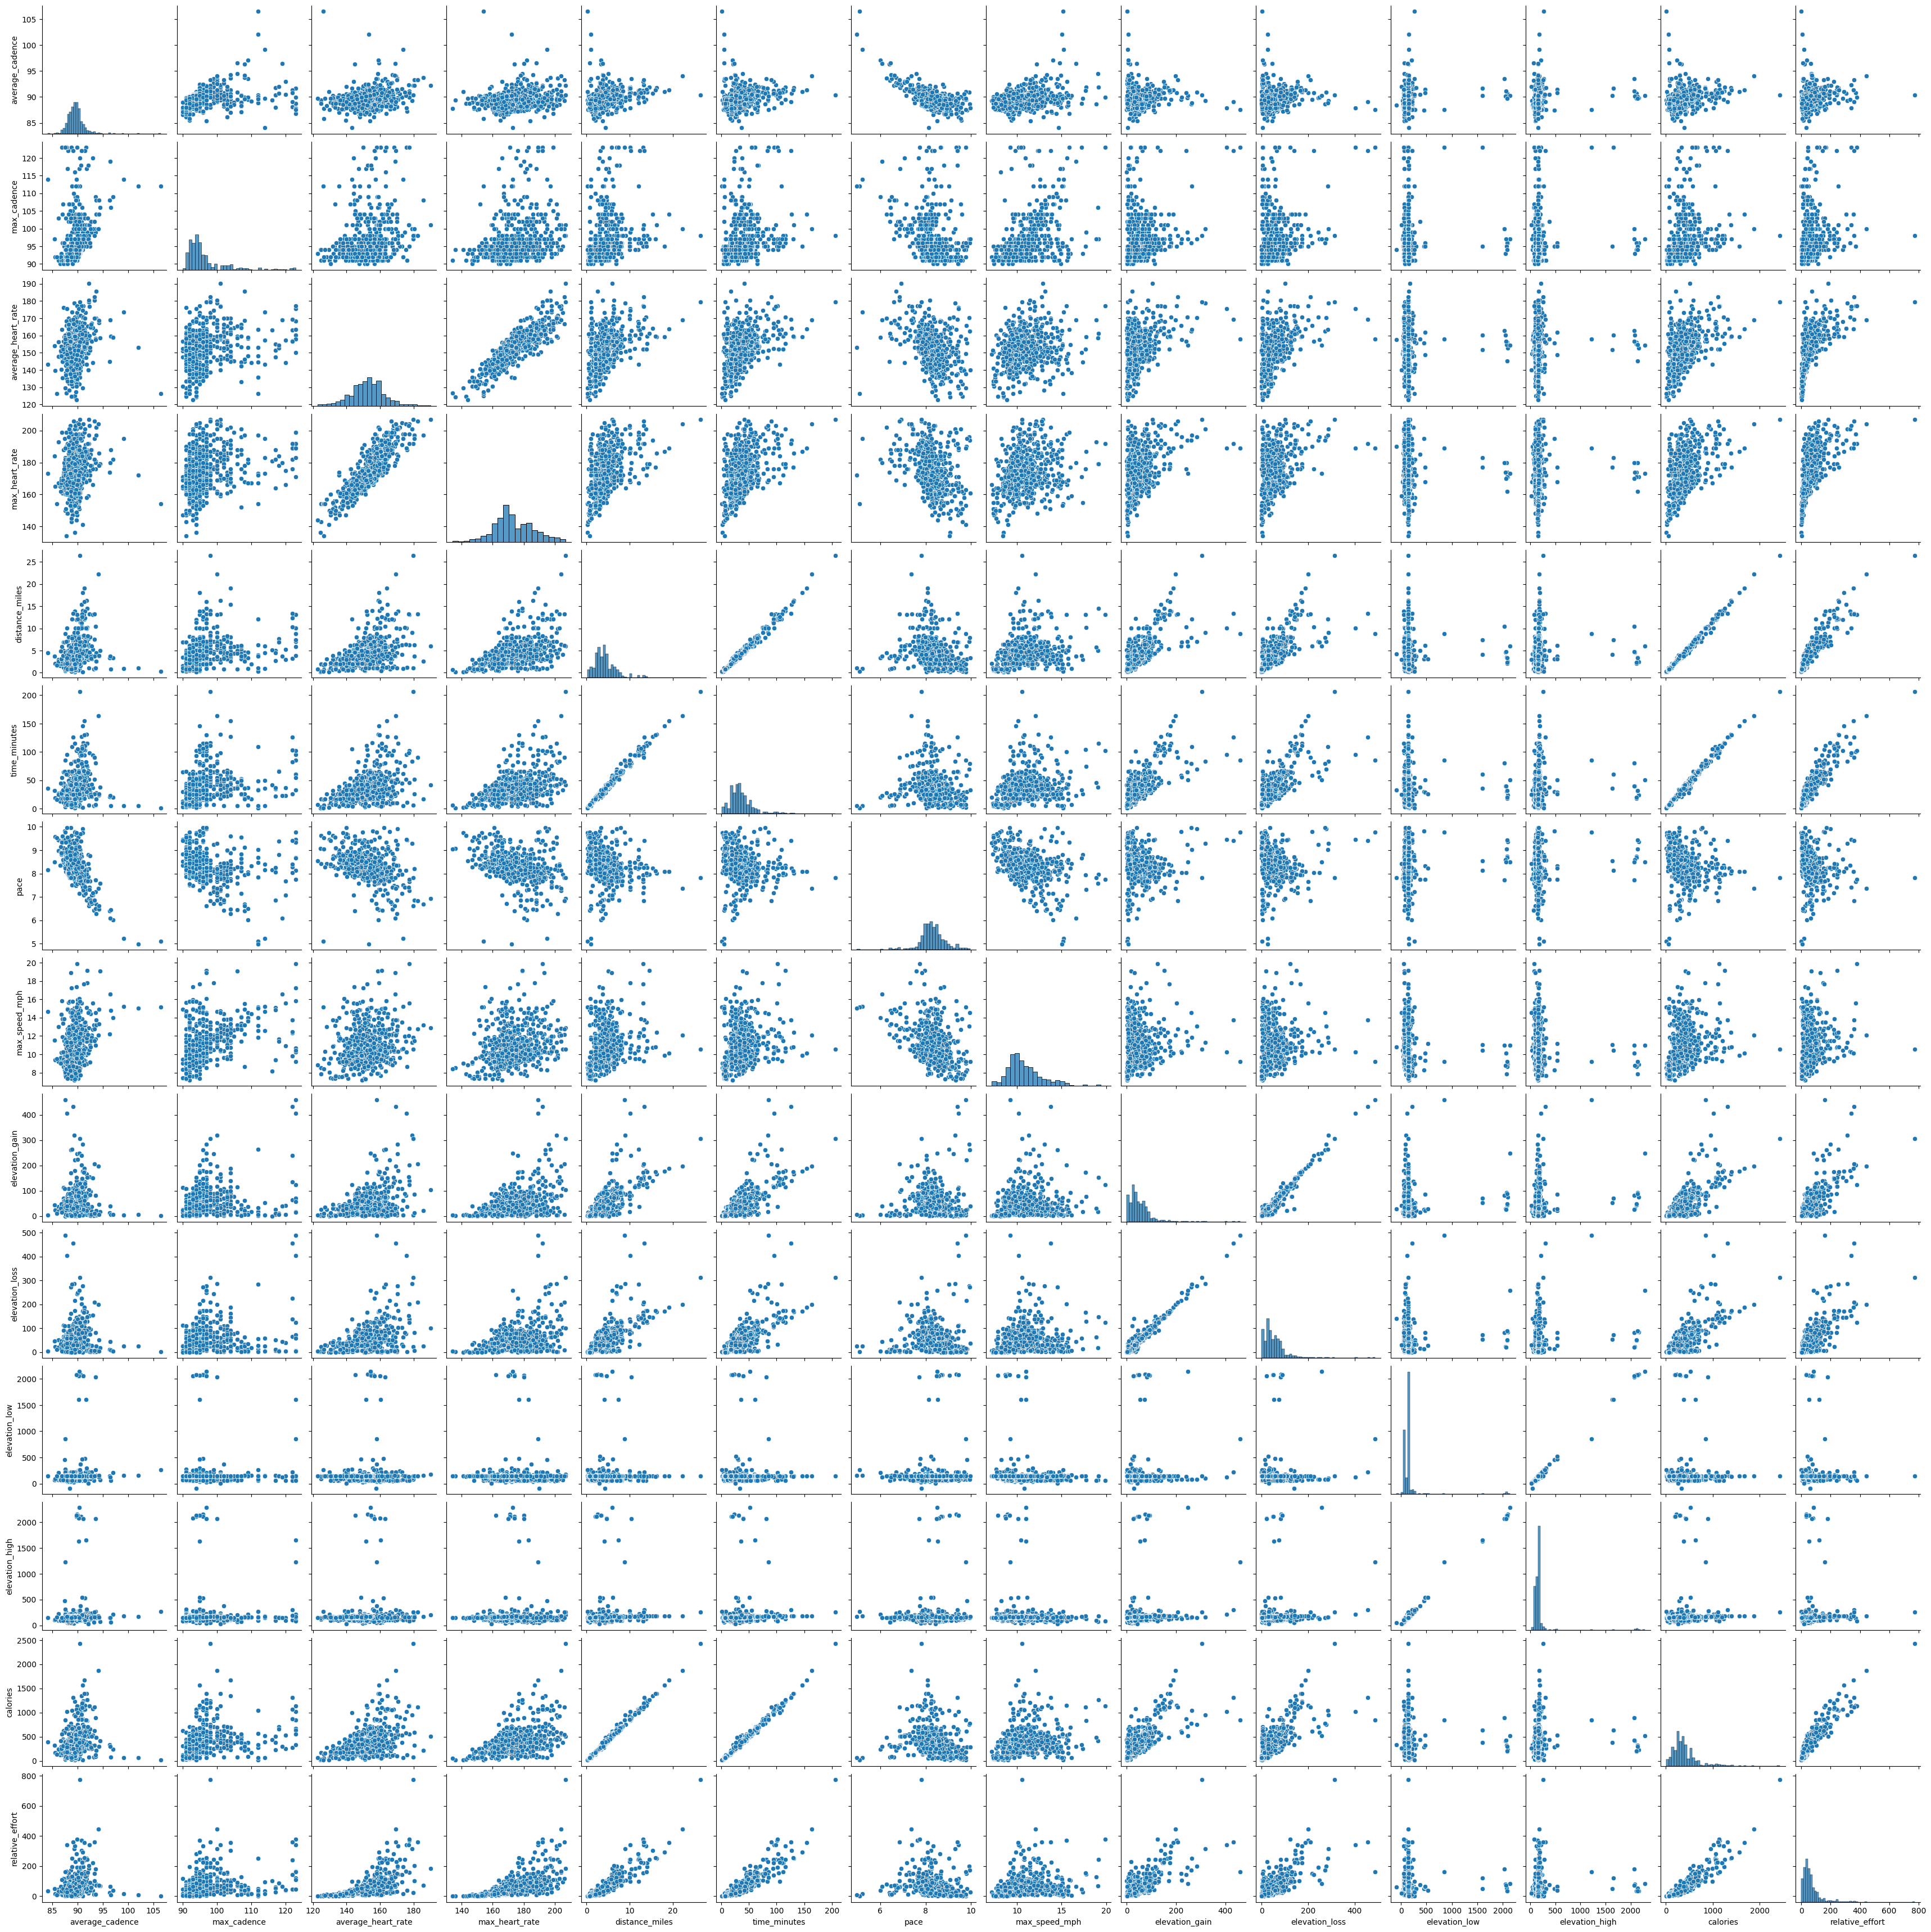

In [269]:
# going to relook at relatoinships after the filtered out data
df = run_data2[run_data2['deactivate']==False]
sns.pairplot(df, vars=cols)
plt.show()

In [270]:

# max speed mph set to the average
# average heart rate use max heart rate where i can, then impute to the average 
### could impute the one for the given distance
# avergage cadence set to the mean
# max cadence set to the mean
col_list = ["max_cadence", "average_cadence",  "max_speed_mph", "average_heart_rate"]
run_data2[col_list] = run_data2[col_list].fillna(run_data2[col_list].mean())

In [271]:

# average vs max heart rate looks linear so i can fit a line through and then impute the max heart rate for these guys
df = run_data2.copy()
#df = df[df["average_heart_rate"] != run_data2["max_heart_rate"]]
df = df.dropna(subset=['average_heart_rate', 'max_heart_rate'])

model_HR = LinearRegression()
model_HR.fit(df[['average_heart_rate']] , df[['max_heart_rate']])


min_val = df['average_heart_rate'].min()
max_val = df['average_heart_rate'].max()

# formatting
x_vals = np.linspace(min_val, max_val, 100).reshape(-1, 1)

# predict for those values
x_vals_df = pd.DataFrame(x_vals, columns=['average_heart_rate'])
y_vals = model_HR.predict(x_vals_df)

r2 = model_HR.score(df[['average_heart_rate']], df[['max_heart_rate']])

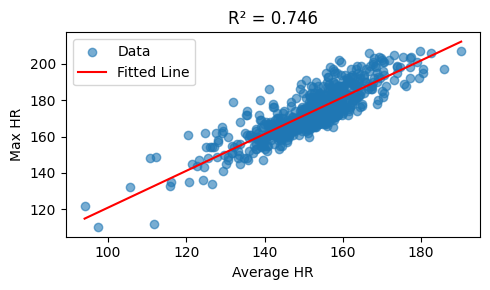

In [272]:
# plotting 
plt.figure(figsize=(5, 3))
plt.scatter(df[['average_heart_rate']], df[['max_heart_rate']], label='Data', alpha=0.6)
plt.plot(x_vals, y_vals, color='red', label='Fitted Line')
plt.xlabel('Average HR')
plt.ylabel('Max HR')
plt.title(f'R² = {r2:.3f}')
plt.legend()
plt.tight_layout()
plt.show()

In [273]:

# define the rows to replace where heart rate is missing
mask = (
    (run_data2['max_heart_rate'].isna()) &
    run_data2['average_heart_rate'].notna()
)

# extracting the average heart rate values that i'm gonna use to impute max heart rate
avg_hr_values = run_data2.loc[mask, 'average_heart_rate'].values.reshape(-1, 1)

# predict the max heart rate
avg_hr_df = pd.DataFrame(avg_hr_values, columns=['average_heart_rate'])
predicted_max_hr = model_HR.predict(avg_hr_df)

# replace max_heart_rate rows with predicted values
run_data2.loc[mask, 'max_heart_rate'] = predicted_max_hr


In [274]:
# elevation gain or loss should prolly be set to 0, also these are basically saying the same thing so i should prolly drop one in the modeling
run_data2["elevation_gain"] = run_data2["elevation_gain"].fillna(0)
run_data2["elevation_loss"] = run_data2["elevation_loss"].fillna(0)

In [275]:
# thought i could replace with the elevation where i had a lat and long but it turns out 
# the data is missing so i cant replace with the average of the elevation of the lat and long
run_data2['latitude'][run_data2['elevation_low'].isna()]

514    NaN
560    NaN
562    NaN
564    NaN
572    NaN
604    NaN
786    NaN
798    NaN
802    NaN
827    NaN
855    NaN
898    NaN
1076   NaN
1129   NaN
1274   NaN
Name: latitude, dtype: float64

In [276]:
# i think i'm actually going to replace the elevation with the average elevation in that same month and year assuming i would be in the same place 
# this falls apart if i was traveling for some reason...
# getting the average for the month
run_data2['year'] = run_data2['activity_date'].dt.year
run_data2['month'] = run_data2['activity_date'].dt.month
avg_elevation_by_month = run_data2.groupby(['year', 'month'])['elevation_low'].mean().reset_index()


# future ideas if i get more data that is NA for here
# could replace the data with the elevation that is most frequent in that month
# i could also replace with the run before or after or an average of the 3 days before and after or something like that. 
# just need to think about misssing sequential days 


In [277]:
# replacing the data, going to do both right now but will drop one later
run_data2['year_month'] = run_data2['activity_date'].dt.to_period('M')
monthly_avg = run_data2.groupby('year_month')['elevation_low'].transform('mean')
run_data2['elevation_low'] = run_data2['elevation_low'].fillna(monthly_avg)


run_data2['year_month'] = run_data2['activity_date'].dt.to_period('M')
monthly_avg = run_data2.groupby('year_month')['elevation_high'].transform('mean')
run_data2['elevation_high'] = run_data2['elevation_high'].fillna(monthly_avg)


In [278]:
# calories can use distance to impute since its also linear, 
# but honestly i feel like my watch is just calculating calroies based on a formula that has distance so 
# could just remove calories as it feels a bit redundant

df = run_data2.dropna(subset=['calories'])


X = df[['distance_miles']]  # 2D DataFrame
y = df[['calories']]

# Fit the model
model_cal = LinearRegression()
model_cal.fit(X, y)

# Get min and max as scalar numbers
min_val = X['distance_miles'].min()
max_val = X['distance_miles'].max()

# Create evenly spaced values between min and max, reshape to 2D
x_vals = np.linspace(min_val, max_val, 100).reshape(-1, 1)

# Predict for those values
x_vals_df = pd.DataFrame(x_vals, columns=['distance_miles'])
y_vals = model_cal.predict(x_vals_df)

r2 = model_cal.score(df[['distance_miles']], df[['calories']])

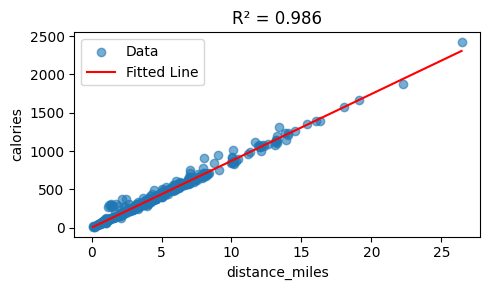

In [279]:
#checking it 
plt.figure(figsize=(5, 3))
plt.scatter(X, y, label='Data', alpha=0.6)
plt.plot(x_vals, y_vals, color='red', label='Fitted Line')
plt.xlabel('distance_miles')
plt.ylabel('calories')
plt.title(f'R² = {r2:.3f}')
plt.legend()
plt.tight_layout()
plt.show()

In [280]:
# data to replace
mask = run_data2['calories'].isna()
cal_for_replace = pd.DataFrame(run_data2.loc[mask, 'distance_miles'].values, columns=['distance_miles'])

# predict 
predicted_cal = model_cal.predict(cal_for_replace)

# fill missing values
run_data2.loc[mask, 'calories'] = predicted_cal

In [285]:
# going to remove the data where relative effort is missing 
# because relative effort is a bit tricky to impute for now i may come back to this
run_data2=run_data2.dropna(subset=['relative_effort'])

In [286]:
# checking to make sure i have no missing data
missing_counts = run_data2[cols].isna().sum()
print(missing_counts)

average_cadence       0
max_cadence           0
average_heart_rate    0
max_heart_rate        0
distance_miles        0
time_minutes          0
pace                  0
max_speed_mph         0
elevation_gain        0
elevation_loss        0
elevation_low         0
elevation_high        0
calories              0
relative_effort       0
dtype: int64


In [287]:
# making sure datetime is date and time and trying to get averages by week
run_data2['activity_date'] = pd.to_datetime(run_data2['activity_date'])

run_data2['week_start'] = (
    run_data2['activity_date'] - pd.to_timedelta(run_data2['activity_date'].dt.dayofweek, unit='d')
).dt.normalize()


In [293]:

# Summarize weekly training
weekly_summary = run_data2.groupby('week_start').agg(
    total_mileage=('distance_miles', 'sum'),
    # weighted average solonger runs influence the average more than shorter ones
    avg_pace=('pace', lambda x: np.average(x, weights=run_data2.loc[x.index, 'distance_miles'])), 
    longest_run=('distance_miles', 'max'),
    avg_hr=('average_heart_rate', 'mean'),
    avg_cadence=('average_cadence', 'mean'),
    num_runs=('distance_miles', 'count'),
    total_elevation_gain = ('elevation_gain', 'sum'),
    elevation_level = ('elevation_high', 'mean'),
    avg_calories= ('calories', 'mean'),
    max_calories = ('calories', 'max'),
    fastest_pace = ('pace', 'min'),
    mean_effort = ('relative_effort', 'mean')
).reset_index()

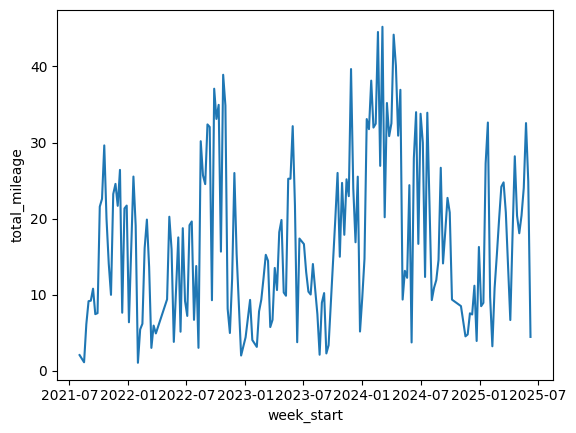

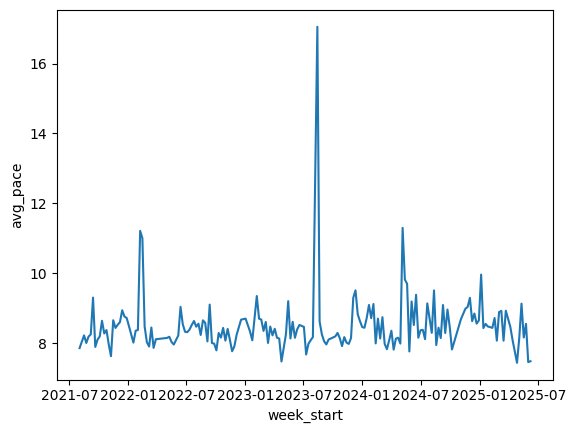

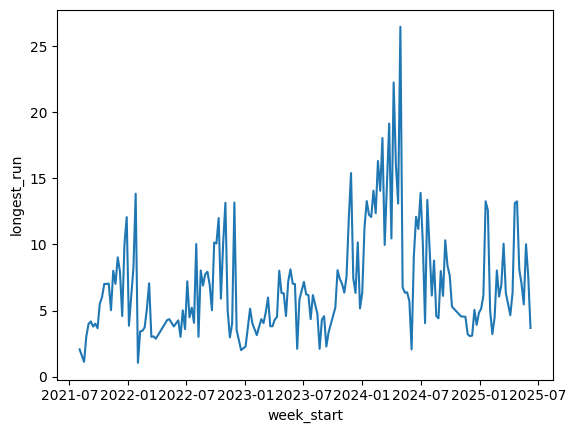

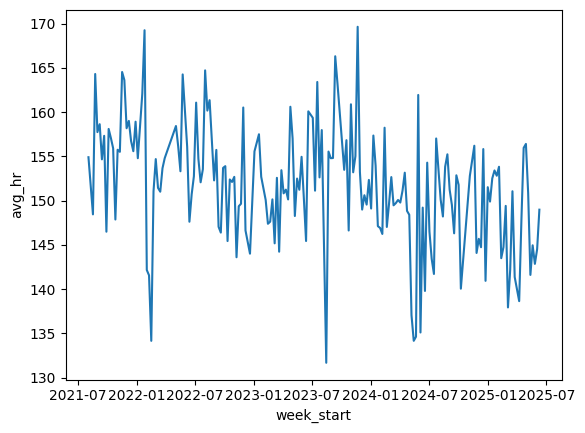

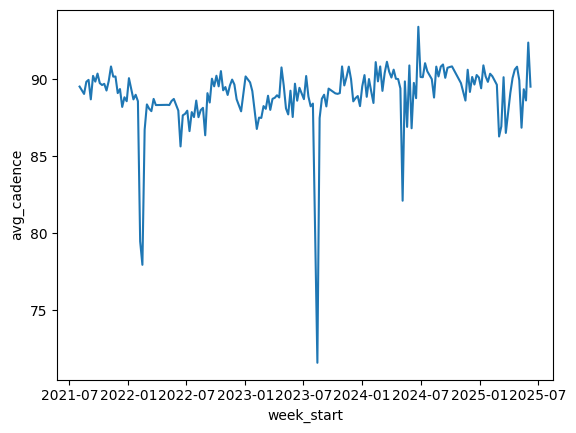

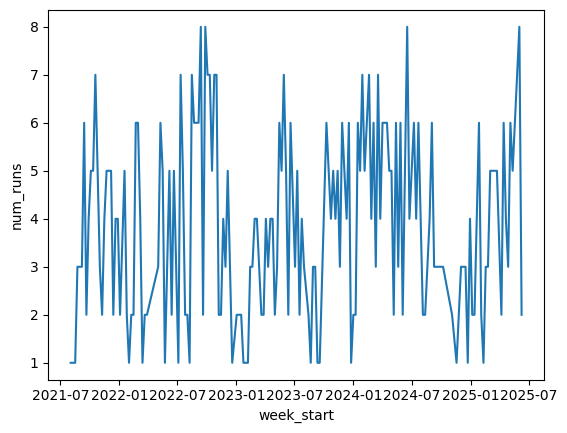

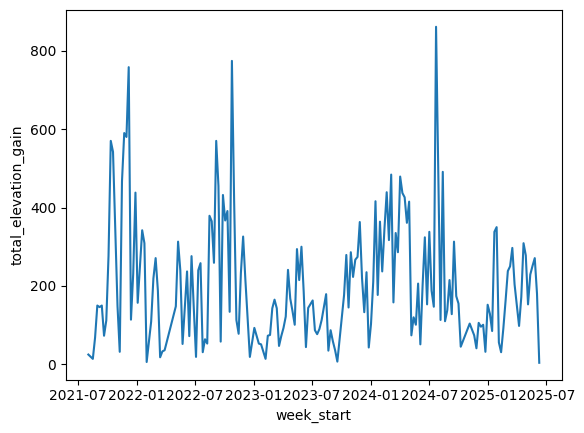

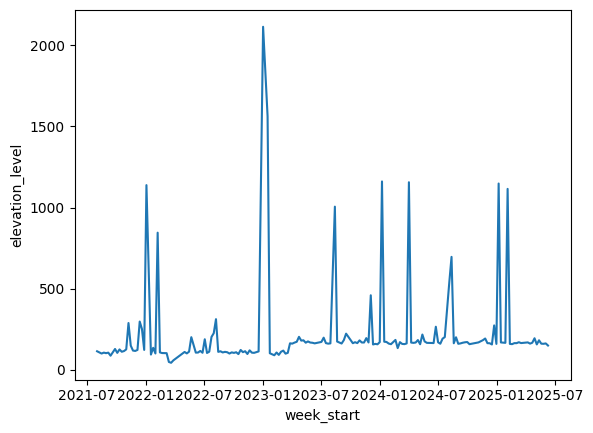

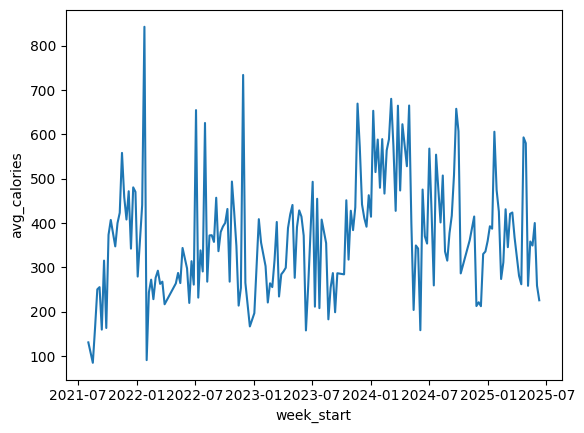

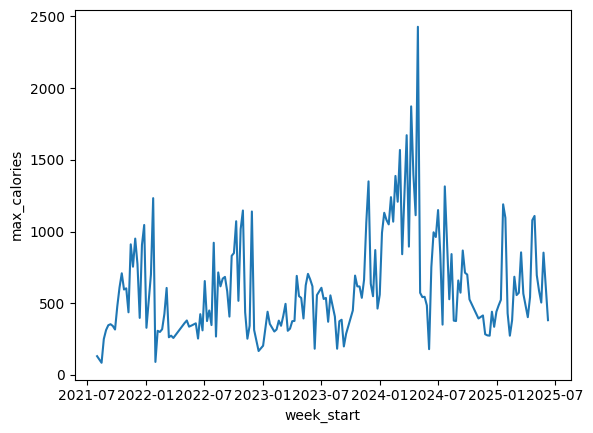

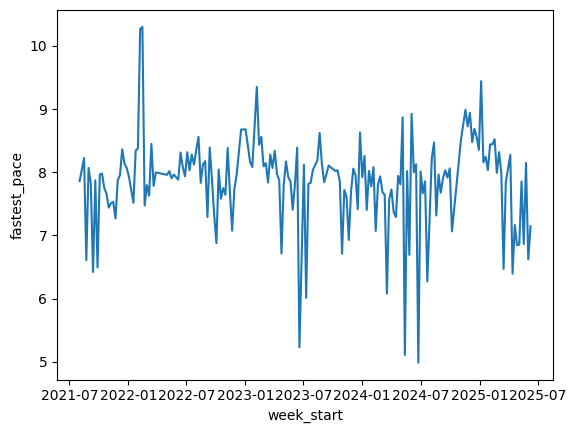

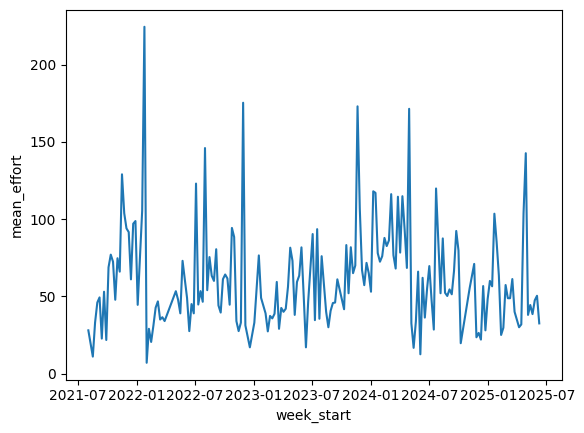

In [294]:


averages_col = ['total_mileage', 'avg_pace', 'longest_run', 'avg_hr', 'avg_cadence', 'num_runs', 'total_elevation_gain', 'elevation_level', 'avg_calories', 'max_calories', 'fastest_pace', 'mean_effort']

for col in averages_col:
    sns.lineplot(x=weekly_summary['week_start'], y=weekly_summary[col])
    plt.show()

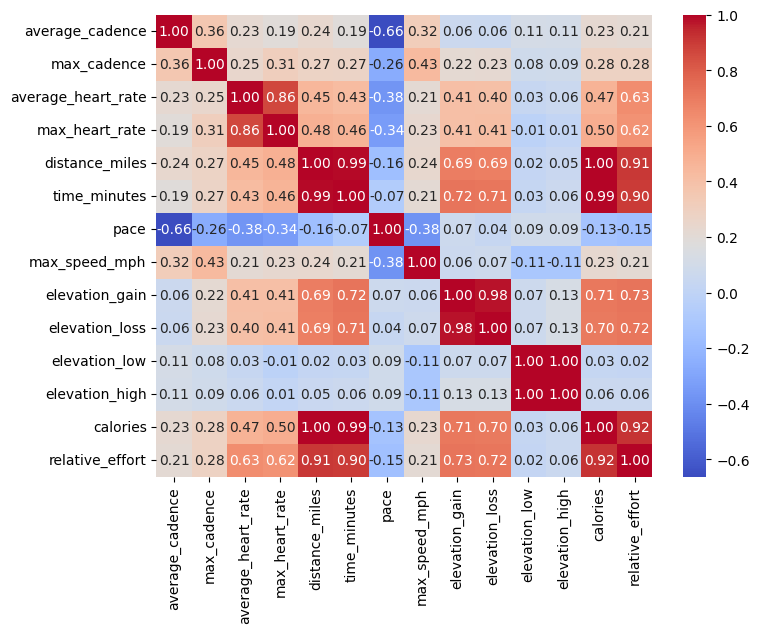

In [295]:
# looking to see how correlated variables are

X_selected = run_data2[cols][run_data2['deactivate']==False]

# Correlation heatmap
corr = X_selected.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [296]:
# saving the cleaned data for simplicity 
run_data2_clean = run_data2[run_data2['deactivate'] == False].copy()
run_data2_clean.to_csv("/Users/Nicole/strava_running/personal_running_data/activities_cleaned.csv")